# B-scan from a metal cylinder (2D)

This example uses the same geometry as the previous (A-scan) example but this time a B-scan is created. A B-scan is composed of multiple traces (A-scans) recorded as the source and receiver are moved over the target, in this case the metal cylinder. The input needed to create the model is:

### my_cylinder_Bscan_2D.in

In [1]:
%%writefile gprMax/user_models/cylinder_Bscan_2D.in
#soil_peplinski: 0.5 0.5 2.0 2.66 0.001 0.25 my_soil
------------------------------------------------------------
#domain: 1.0 1.0 0.1
#dx_dy_dz: 0.002 0.002 0.002
#time_window: 12e-9
------------------------------------------------------------
#fractal_box: 0 0 0 1 0.75 0.1 1.5 1 1 1 50 my_soil my_soil_box 42 n
#add_surface_roughness: 0 0 0.1 0.1 0.1 0.1 1.5 1 1 0.065 0.080 my_soil_box
#cylinder: 0.33 0.33 0 0.33 0.33 0.002 0.01 pec y
-------------------------------------------------------------
-------------------------------------------------------------
#rx: 0.1125 0.1525 0
#src_steps: 0.002 0.0 0
#rx_steps: 0.002 0.0 0
------------------------------------------------------------
#waveform: ricker 1 1.5e9 my_ricker
#hertzian_dipole: z 0.150 0.170 0 my_ricker
#messages: y

Overwriting gprMax/user_models/cylinder_Bscan_2D.in


The differences between this input file and the one from the A-scan are the x coordinates of the source and receiver, and the commands needed to move the source and receiver. As before, the source and receiver are offset by 40mm from each other as before but they are now shifted to a starting position for the scan. The ``#src_steps`` command is used to move every source in the model by specified steps each time the model is run. Similarly, the ``#rx_steps`` command is used to move every receiver in the model by specified steps each time the model is run. Note, the same functionality can be achieved by using a block of Python code in the input file to move the source and receiver individually (for further details see the Python section of the User Guide).

## Run the model

To run the model to create a B-scan you must pass an optional argument to specify the number of times the model should be run. In this case this is the number of A-scans (traces) that will comprise the B-scan. For a B-scan over a distance of 120mm with a step of 2mm that is 60 A-scans. You can now run the model using:
    
    python -m gprMax user_models/cylinder_Bscan_2D.in -n 60

In [2]:
import os
from gprMax.gprMax import api

filename = os.path.join('gprMax', 'user_models', 'cylinder_Bscan_2D.in')
api(filename, n=200, geometry_only=False, gpu=[0])


=== Electromagnetic modelling software based on the Finite-Difference Time-Domain (FDTD) method 

    www.gprmax.com   __  __
     __ _ _ __  _ __|  \/  | __ ___  __
    / _` | '_ \| '__| |\/| |/ _` \ \/ /
   | (_| | |_) | |  | |  | | (_| |>  <
    \__, | .__/|_|  |_|  |_|\__,_/_/\_\
    |___/|_|
                     v3.1.4 (Big Smoke)

 Copyright (C) 2015-2018: The University of Edinburgh
 Authors: Craig Warren and Antonis Giannopoulos

 gprMax is free software: you can redistribute it and/or modify it under the
  terms of the GNU General Public License as published by the Free Software
  Foundation, either version 3 of the License, or (at your option) any later
  version.
 gprMax is distributed in the hope that it will be useful, but WITHOUT ANY
  WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR
  A PARTICULAR PURPOSE.  See the GNU General Public License for more details.
 You should have received a copy of the GNU General Public License along with
  gpr

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D1.out

Running simulation, model 1/200: 100%|█████| 3117/3117 [00:50<00:00, 61.65it/s]
Total memory (RAM) used: ~1.08GB
Solving time [HH:MM:SS]: 0:00:51.549344

--- Model 2/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ----------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 2, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial d

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D2.out

Running simulation, model 2/200: 100%|█████| 3117/3117 [00:52<00:00, 59.25it/s]
Total memory (RAM) used: ~1.36GB
Solving time [HH:MM:SS]: 0:00:53.594535

--- Model 3/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ----------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 3, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial d

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D3.out

Running simulation, model 3/200: 100%|█████| 3117/3117 [00:50<00:00, 61.47it/s]
Total memory (RAM) used: ~1.58GB
Solving time [HH:MM:SS]: 0:00:51.689395

--- Model 4/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ----------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 4, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial d

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D4.out

Running simulation, model 4/200: 100%|█████| 3117/3117 [00:51<00:00, 60.18it/s]
Total memory (RAM) used: ~1.82GB
Solving time [HH:MM:SS]: 0:00:52.789078

--- Model 5/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ----------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 5, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial d

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D5.out

Running simulation, model 5/200: 100%|█████| 3117/3117 [00:50<00:00, 62.20it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.099164

--- Model 6/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ----------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 6, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial di

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D6.out

Running simulation, model 6/200: 100%|█████| 3117/3117 [00:50<00:00, 62.06it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.210102

--- Model 7/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ----------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 7, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial di

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D7.out

Running simulation, model 7/200: 100%|█████| 3117/3117 [00:50<00:00, 62.18it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.109770

--- Model 8/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ----------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 8, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial di

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D8.out

Running simulation, model 8/200: 100%|█████| 3117/3117 [00:50<00:00, 61.02it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.215113

--- Model 9/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ----------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 9, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial di

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D9.out

Running simulation, model 9/200: 100%|█████| 3117/3117 [00:50<00:00, 62.15it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.139223

--- Model 10/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 10, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial d

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D10.out

Running simulation, model 10/200: 100%|████| 3117/3117 [00:50<00:00, 62.30it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.019500

--- Model 11/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 11, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D11.out

Running simulation, model 11/200: 100%|████| 3117/3117 [00:49<00:00, 62.37it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:50.960855

--- Model 12/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 12, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D12.out

Running simulation, model 12/200: 100%|████| 3117/3117 [00:49<00:00, 62.37it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:50.962871

--- Model 13/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 13, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D13.out

Running simulation, model 13/200: 100%|████| 3117/3117 [00:50<00:00, 62.30it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.019266

--- Model 14/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 14, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D14.out

Running simulation, model 14/200: 100%|████| 3117/3117 [00:49<00:00, 62.37it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:50.962680

--- Model 15/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 15, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D15.out

Running simulation, model 15/200: 100%|████| 3117/3117 [00:50<00:00, 62.30it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.014375

--- Model 16/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 16, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D16.out

Running simulation, model 16/200: 100%|████| 3117/3117 [00:49<00:00, 62.37it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:50.959063

--- Model 17/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 17, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D17.out

Running simulation, model 17/200: 100%|████| 3117/3117 [00:50<00:00, 61.21it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.006461

--- Model 18/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 18, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D18.out

Running simulation, model 18/200: 100%|████| 3117/3117 [00:50<00:00, 62.30it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.027988

--- Model 19/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 19, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D19.out

Running simulation, model 19/200: 100%|████| 3117/3117 [00:49<00:00, 62.37it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:50.963711

--- Model 20/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 20, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D20.out

Running simulation, model 20/200: 100%|████| 3117/3117 [00:50<00:00, 62.24it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.068129

--- Model 21/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 21, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D21.out

Running simulation, model 21/200: 100%|████| 3117/3117 [00:49<00:00, 62.37it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:50.961480

--- Model 22/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 22, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D22.out

Running simulation, model 22/200: 100%|████| 3117/3117 [00:50<00:00, 62.25it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.061133

--- Model 23/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 23, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D23.out

Running simulation, model 23/200: 100%|████| 3117/3117 [00:49<00:00, 62.37it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:50.960000

--- Model 24/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 24, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D24.out

Running simulation, model 24/200: 100%|████| 3117/3117 [00:51<00:00, 60.59it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:52.439457

--- Model 25/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 25, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D25.out

Running simulation, model 25/200: 100%|████| 3117/3117 [00:51<00:00, 60.80it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:52.247809

--- Model 26/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 26, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D26.out

Running simulation, model 26/200: 100%|████| 3117/3117 [00:50<00:00, 61.22it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.898313

--- Model 27/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 27, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D27.out

Running simulation, model 27/200: 100%|████| 3117/3117 [00:51<00:00, 60.22it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:52.742844

--- Model 28/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 28, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D28.out

Running simulation, model 28/200: 100%|████| 3117/3117 [00:51<00:00, 60.88it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:52.184109

--- Model 29/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 29, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D29.out

Running simulation, model 29/200: 100%|████| 3117/3117 [00:52<00:00, 59.86it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:53.057113

--- Model 30/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 30, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D30.out

Running simulation, model 30/200: 100%|████| 3117/3117 [00:50<00:00, 62.29it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.024926

--- Model 31/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 31, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D31.out

Running simulation, model 31/200: 100%|████| 3117/3117 [00:50<00:00, 61.40it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.750758

--- Model 32/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 32, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D32.out

Running simulation, model 32/200: 100%|████| 3117/3117 [00:51<00:00, 60.53it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:52.553086

--- Model 33/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 33, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D33.out

Running simulation, model 33/200: 100%|████| 3117/3117 [00:51<00:00, 60.39it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:52.666199

--- Model 34/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 34, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D34.out

Running simulation, model 34/200: 100%|████| 3117/3117 [00:52<00:00, 59.91it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:53.011262

--- Model 35/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 35, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D35.out

Running simulation, model 35/200: 100%|████| 3117/3117 [00:50<00:00, 62.13it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:51.215469

--- Model 36/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 36, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D36.out

Running simulation, model 36/200: 100%|████| 3117/3117 [00:52<00:00, 59.89it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:53.111594

--- Model 37/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 37, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D37.out

Running simulation, model 37/200: 100%|████| 3117/3117 [00:50<00:00, 61.43it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:51.722297

--- Model 38/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 38, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D38.out

Running simulation, model 38/200: 100%|████| 3117/3117 [00:51<00:00, 60.91it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:52.291727

--- Model 39/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 39, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D39.out

Running simulation, model 39/200: 100%|████| 3117/3117 [00:51<00:00, 60.14it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:52.816437

--- Model 40/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 40, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D40.out

Running simulation, model 40/200: 100%|████| 3117/3117 [00:51<00:00, 60.68it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:52.359270

--- Model 41/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 41, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D41.out

Running simulation, model 41/200: 100%|████| 3117/3117 [00:51<00:00, 59.97it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:53.038020

--- Model 42/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 42, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D42.out

Running simulation, model 42/200: 100%|████| 3117/3117 [00:52<00:00, 59.26it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:53.581187

--- Model 43/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 43, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D43.out

Running simulation, model 43/200: 100%|████| 3117/3117 [00:52<00:00, 57.83it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:53.587602

--- Model 44/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 44, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D44.out

Running simulation, model 44/200: 100%|████| 3117/3117 [00:52<00:00, 59.72it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:53.261574

--- Model 45/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 45, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D45.out

Running simulation, model 45/200: 100%|████| 3117/3117 [00:52<00:00, 59.44it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:53.476465

--- Model 46/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 46, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D46.out

Running simulation, model 46/200: 100%|████| 3117/3117 [00:51<00:00, 60.07it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:52.951363

--- Model 47/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 47, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D47.out

Running simulation, model 47/200: 100%|████| 3117/3117 [00:50<00:00, 61.72it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.484805

--- Model 48/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 48, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D48.out

Running simulation, model 48/200: 100%|████| 3117/3117 [00:50<00:00, 62.26it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:51.050176

--- Model 49/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 49, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D49.out

Running simulation, model 49/200: 100%|████| 3117/3117 [00:50<00:00, 61.27it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:51.860863

--- Model 50/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 50, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D50.out

Running simulation, model 50/200: 100%|████| 3117/3117 [00:50<00:00, 62.26it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:51.045863

--- Model 51/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 51, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D51.out

Running simulation, model 51/200: 100%|████| 3117/3117 [00:50<00:00, 62.26it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.049047

--- Model 52/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 52, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D52.out

Running simulation, model 52/200: 100%|████| 3117/3117 [00:50<00:00, 62.04it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.226703

--- Model 53/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 53, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D53.out

Running simulation, model 53/200: 100%|████| 3117/3117 [00:50<00:00, 62.26it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.048523

--- Model 54/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 54, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D54.out

Running simulation, model 54/200: 100%|████| 3117/3117 [00:50<00:00, 62.22it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.076535

--- Model 55/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 55, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D55.out

Running simulation, model 55/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:50.895008

--- Model 56/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 56, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D56.out

Running simulation, model 56/200: 100%|████| 3117/3117 [00:50<00:00, 62.24it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:51.067031

--- Model 57/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 57, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D57.out

Running simulation, model 57/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:50.893621

--- Model 58/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 58, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D58.out

Running simulation, model 58/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:50.895949

--- Model 59/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 59, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D59.out

Running simulation, model 59/200: 100%|████| 3117/3117 [00:49<00:00, 62.34it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:50.982844

--- Model 60/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 60, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D60.out

Running simulation, model 60/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:50.898148

--- Model 61/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 61, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D61.out

Running simulation, model 61/200: 100%|████| 3117/3117 [00:50<00:00, 62.34it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:50.986816

--- Model 62/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 62, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D62.out

Running simulation, model 62/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:50.893070

--- Model 63/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 63, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D63.out

Running simulation, model 63/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:50.894863

--- Model 64/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 64, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D64.out

Running simulation, model 64/200: 100%|████| 3117/3117 [00:49<00:00, 57.42it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:50.985734

--- Model 65/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 65, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D65.out

Running simulation, model 65/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:50.895668

--- Model 66/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 66, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D66.out

Running simulation, model 66/200: 100%|████| 3117/3117 [00:50<00:00, 62.34it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:50.984172

--- Model 67/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 67, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D67.out

Running simulation, model 67/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:50.897254

--- Model 68/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 68, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D68.out

Running simulation, model 68/200: 100%|████| 3117/3117 [00:50<00:00, 62.33it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:50.988918

--- Model 69/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 69, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D69.out

Running simulation, model 69/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:50.891949

--- Model 70/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 70, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D70.out

Running simulation, model 70/200: 100%|████| 3117/3117 [00:49<00:00, 62.44it/s]
Total memory (RAM) used: ~2.09GB
Solving time [HH:MM:SS]: 0:00:50.902203

--- Model 71/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 71, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D71.out

Running simulation, model 71/200: 100%|████| 3117/3117 [00:50<00:00, 62.34it/s]
Total memory (RAM) used: ~2.1GB
Solving time [HH:MM:SS]: 0:00:50.985371

--- Model 72/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 72, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D72.out

Running simulation, model 72/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.16GB
Solving time [HH:MM:SS]: 0:00:50.894457

--- Model 73/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 73, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D73.out

Running simulation, model 73/200: 100%|████| 3117/3117 [00:50<00:00, 62.34it/s]
Total memory (RAM) used: ~2.15GB
Solving time [HH:MM:SS]: 0:00:50.985250

--- Model 74/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 74, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D74.out

Running simulation, model 74/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.900203

--- Model 75/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 75, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D75.out

Running simulation, model 75/200: 100%|████| 3117/3117 [00:50<00:00, 62.23it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.072066

--- Model 76/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 76, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D76.out

Running simulation, model 76/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.897391

--- Model 77/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 77, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D77.out

Running simulation, model 77/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.893555

--- Model 78/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 78, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D78.out

Running simulation, model 78/200: 100%|████| 3117/3117 [00:50<00:00, 62.24it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.063680

--- Model 79/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 79, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D79.out

Running simulation, model 79/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.894133

--- Model 80/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 80, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D80.out

Running simulation, model 80/200: 100%|████| 3117/3117 [00:49<00:00, 62.34it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.982539

--- Model 81/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 81, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D81.out

Running simulation, model 81/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.892031

--- Model 82/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 82, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D82.out

Running simulation, model 82/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.894332

--- Model 83/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 83, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D83.out

Running simulation, model 83/200: 100%|████| 3117/3117 [00:50<00:00, 62.23it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.070578

--- Model 84/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 84, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D84.out

Running simulation, model 84/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.899238

--- Model 85/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 85, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D85.out

Running simulation, model 85/200: 100%|████| 3117/3117 [00:50<00:00, 62.23it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.071414

--- Model 86/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 86, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D86.out

Running simulation, model 86/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.895301

--- Model 87/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 87, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D87.out

Running simulation, model 87/200: 100%|████| 3117/3117 [00:50<00:00, 62.24it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.064789

--- Model 88/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 88, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D88.out

Running simulation, model 88/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.895660

--- Model 89/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 89, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D89.out

Running simulation, model 89/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.894324

--- Model 90/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 90, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D90.out

Running simulation, model 90/200: 100%|████| 3117/3117 [00:50<00:00, 62.23it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.069078

--- Model 91/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 91, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D91.out

Running simulation, model 91/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.897086

--- Model 92/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 92, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D92.out

Running simulation, model 92/200: 100%|████| 3117/3117 [00:50<00:00, 62.23it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.073355

--- Model 93/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 93, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D93.out

Running simulation, model 93/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.893656

--- Model 94/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 94, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D94.out

Running simulation, model 94/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.899707

--- Model 95/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 95, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D95.out

Running simulation, model 95/200: 100%|████| 3117/3117 [00:50<00:00, 62.23it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.068523

--- Model 96/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 96, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D96.out

Running simulation, model 96/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.894477

--- Model 97/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 97, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D97.out

Running simulation, model 97/200: 100%|████| 3117/3117 [00:50<00:00, 62.24it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.067668

--- Model 98/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 98, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D98.out

Running simulation, model 98/200: 100%|████| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.896586

--- Model 99/200, input file: gprMax/user_models/cylinder_Bscan_2D.in ---------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 99, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial 

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D99.out

Running simulation, model 99/200: 100%|████| 3117/3117 [00:50<00:00, 62.23it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.071934

--- Model 100/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 100, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatial

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D100.out

Running simulation, model 100/200: 100%|███| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.895910

--- Model 101/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 101, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D101.out

Running simulation, model 101/200: 100%|███| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.894555

--- Model 102/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 102, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D102.out

Running simulation, model 102/200: 100%|███| 3117/3117 [00:50<00:00, 62.24it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.067563

--- Model 103/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 103, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D103.out

Running simulation, model 103/200: 100%|███| 3117/3117 [00:49<00:00, 62.45it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.892430

--- Model 104/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 104, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D104.out

Running simulation, model 104/200: 100%|███| 3117/3117 [00:51<00:00, 61.04it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.056430

--- Model 105/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 105, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D105.out

Running simulation, model 105/200: 100%|███| 3117/3117 [00:50<00:00, 62.18it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.111578

--- Model 106/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 106, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D106.out

Running simulation, model 106/200: 100%|███| 3117/3117 [00:52<00:00, 59.73it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:53.150230

--- Model 107/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 107, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D107.out

Running simulation, model 107/200: 100%|███| 3117/3117 [00:51<00:00, 61.11it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.987609

--- Model 108/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 108, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D108.out

Running simulation, model 108/200: 100%|███| 3117/3117 [00:50<00:00, 62.18it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.114750

--- Model 109/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 109, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D109.out

Running simulation, model 109/200: 100%|███| 3117/3117 [00:51<00:00, 60.37it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.698082

--- Model 110/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 110, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D110.out

Running simulation, model 110/200: 100%|███| 3117/3117 [00:50<00:00, 61.32it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.817223

--- Model 111/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 111, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D111.out

Running simulation, model 111/200: 100%|███| 3117/3117 [00:50<00:00, 61.40it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.757883

--- Model 112/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 112, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D112.out

Running simulation, model 112/200: 100%|███| 3117/3117 [00:51<00:00, 60.47it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.527430

--- Model 113/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 113, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D113.out

Running simulation, model 113/200: 100%|███| 3117/3117 [00:51<00:00, 60.06it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.878266

--- Model 114/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 114, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D114.out

Running simulation, model 114/200: 100%|███| 3117/3117 [00:50<00:00, 61.28it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.845684

--- Model 115/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 115, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D115.out

Running simulation, model 115/200: 100%|███| 3117/3117 [00:52<00:00, 61.25it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:53.264789

--- Model 116/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 116, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D116.out

Running simulation, model 116/200: 100%|███| 3117/3117 [00:51<00:00, 60.89it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.172863

--- Model 117/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 117, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D117.out

Running simulation, model 117/200: 100%|███| 3117/3117 [00:51<00:00, 60.79it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.329664

--- Model 118/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 118, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D118.out

Running simulation, model 118/200: 100%|███| 3117/3117 [00:51<00:00, 58.03it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.656551

--- Model 119/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 119, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D119.out

Running simulation, model 119/200: 100%|███| 3117/3117 [00:51<00:00, 61.16it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.145223

--- Model 120/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 120, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D120.out

Running simulation, model 120/200: 100%|███| 3117/3117 [00:51<00:00, 59.98it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.998836

--- Model 121/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 121, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D121.out

Running simulation, model 121/200: 100%|███| 3117/3117 [00:51<00:00, 60.35it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.628770

--- Model 122/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 122, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D122.out

Running simulation, model 122/200: 100%|███| 3117/3117 [00:50<00:00, 61.49it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.674937

--- Model 123/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 123, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D123.out

Running simulation, model 123/200: 100%|███| 3117/3117 [00:51<00:00, 60.55it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.465156

--- Model 124/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 124, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D124.out

Running simulation, model 124/200: 100%|███| 3117/3117 [00:50<00:00, 61.17it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.942227

--- Model 125/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 125, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D125.out

Running simulation, model 125/200: 100%|███| 3117/3117 [00:50<00:00, 61.35it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.867152

--- Model 126/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 126, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D126.out

Running simulation, model 126/200: 100%|███| 3117/3117 [00:51<00:00, 61.33it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.116914

--- Model 127/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 127, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D127.out

Running simulation, model 127/200: 100%|███| 3117/3117 [00:51<00:00, 60.95it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.205645

--- Model 128/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 128, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D128.out

Running simulation, model 128/200: 100%|███| 3117/3117 [00:51<00:00, 60.75it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.288777

--- Model 129/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 129, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D129.out

Running simulation, model 129/200: 100%|███| 3117/3117 [00:50<00:00, 61.21it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:51.918598

--- Model 130/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 130, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D130.out

Running simulation, model 130/200: 100%|███| 3117/3117 [00:52<00:00, 59.88it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:53.123301

--- Model 131/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 131, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D131.out

Running simulation, model 131/200: 100%|███| 3117/3117 [00:53<00:00, 58.75it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:54.068633

--- Model 132/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 132, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D132.out

Running simulation, model 132/200: 100%|███| 3117/3117 [00:52<00:00, 59.32it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:53.576051

--- Model 133/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 133, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D133.out

Running simulation, model 133/200: 100%|███| 3117/3117 [00:51<00:00, 60.62it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.485570

--- Model 134/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 134, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D134.out

Running simulation, model 134/200: 100%|███| 3117/3117 [00:51<00:00, 60.52it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.490359

--- Model 135/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 135, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D135.out

Running simulation, model 135/200: 100%|███| 3117/3117 [00:51<00:00, 60.89it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:52.259945

--- Model 136/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 136, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D136.out

Running simulation, model 136/200: 100%|███| 3117/3117 [00:52<00:00, 59.64it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:53.244363

--- Model 137/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 137, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D137.out

Running simulation, model 137/200: 100%|███| 3117/3117 [00:51<00:00, 60.29it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.718457

--- Model 138/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 138, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D138.out

Running simulation, model 138/200: 100%|███| 3117/3117 [00:52<00:00, 59.48it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:53.462785

--- Model 139/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 139, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D139.out

Running simulation, model 139/200: 100%|███| 3117/3117 [00:51<00:00, 60.79it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.267320

--- Model 140/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 140, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D140.out

Running simulation, model 140/200: 100%|███| 3117/3117 [00:50<00:00, 61.68it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:51.524254

--- Model 141/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 141, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D141.out

Running simulation, model 141/200: 100%|███| 3117/3117 [00:51<00:00, 61.08it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.014395

--- Model 142/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 142, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D142.out

Running simulation, model 142/200: 100%|███| 3117/3117 [00:51<00:00, 60.43it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:52.563137

--- Model 143/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 143, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D143.out

Running simulation, model 143/200: 100%|███| 3117/3117 [00:51<00:00, 60.68it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:52.375215

--- Model 144/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 144, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D144.out

Running simulation, model 144/200: 100%|███| 3117/3117 [00:49<00:00, 62.37it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.962250

--- Model 145/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 145, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D145.out

Running simulation, model 145/200: 100%|███| 3117/3117 [00:49<00:00, 62.62it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.756238

--- Model 146/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 146, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D146.out

Running simulation, model 146/200: 100%|███| 3117/3117 [00:49<00:00, 62.61it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.763469

--- Model 147/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 147, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D147.out

Running simulation, model 147/200: 100%|███| 3117/3117 [00:49<00:00, 62.62it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.755895

--- Model 148/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 148, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D148.out

Running simulation, model 148/200: 100%|███| 3117/3117 [00:50<00:00, 61.97it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:51.283504

--- Model 149/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 149, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D149.out

Running simulation, model 149/200: 100%|███| 3117/3117 [00:49<00:00, 62.49it/s]
Total memory (RAM) used: ~2.2GB
Solving time [HH:MM:SS]: 0:00:50.867285

--- Model 150/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 150, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spatia

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D150.out

Running simulation, model 150/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.871070

--- Model 151/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 151, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D151.out

Running simulation, model 151/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.875738

--- Model 152/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 152, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D152.out

Running simulation, model 152/200: 100%|███| 3117/3117 [00:49<00:00, 62.47it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.878859

--- Model 153/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 153, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D153.out

Running simulation, model 153/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.875504

--- Model 154/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 154, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D154.out

Running simulation, model 154/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.872781

--- Model 155/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 155, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D155.out

Running simulation, model 155/200: 100%|███| 3117/3117 [00:49<00:00, 62.49it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.868270

--- Model 156/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 156, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D156.out

Running simulation, model 156/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.870324

--- Model 157/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 157, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D157.out

Running simulation, model 157/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.874441

--- Model 158/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 158, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D158.out

Running simulation, model 158/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.870098

--- Model 159/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 159, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D159.out

Running simulation, model 159/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.870098

--- Model 160/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 160, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D160.out

Running simulation, model 160/200: 100%|███| 3117/3117 [00:49<00:00, 62.47it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.876422

--- Model 161/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 161, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D161.out

Running simulation, model 161/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.870344

--- Model 162/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 162, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D162.out

Running simulation, model 162/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.873184

--- Model 163/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 163, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D163.out

Running simulation, model 163/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.870297

--- Model 164/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 164, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D164.out

Running simulation, model 164/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.869109

--- Model 165/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 165, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D165.out

Running simulation, model 165/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.874258

--- Model 166/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 166, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D166.out

Running simulation, model 166/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.869484

--- Model 167/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 167, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D167.out

Running simulation, model 167/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.876172

--- Model 168/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 168, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D168.out

Running simulation, model 168/200: 100%|███| 3117/3117 [00:49<00:00, 62.49it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.868344

--- Model 169/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 169, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D169.out

Running simulation, model 169/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.873500

--- Model 170/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 170, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D170.out

Running simulation, model 170/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.876551

--- Model 171/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 171, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D171.out

Running simulation, model 171/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.869414

--- Model 172/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 172, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D172.out

Running simulation, model 172/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.872715

--- Model 173/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 173, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D173.out

Running simulation, model 173/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.875320

--- Model 174/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 174, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D174.out

Running simulation, model 174/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.869344

--- Model 175/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 175, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D175.out

Running simulation, model 175/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.871023

--- Model 176/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 176, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D176.out

Running simulation, model 176/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.871152

--- Model 177/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 177, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D177.out

Running simulation, model 177/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.870941

--- Model 178/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 178, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D178.out

Running simulation, model 178/200: 100%|███| 3117/3117 [00:49<00:00, 62.49it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.867191

--- Model 179/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 179, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D179.out

Running simulation, model 179/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.869473

--- Model 180/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 180, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D180.out

Running simulation, model 180/200: 100%|███| 3117/3117 [00:49<00:00, 62.49it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.868211

--- Model 181/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 181, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D181.out

Running simulation, model 181/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.872320

--- Model 182/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 182, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D182.out

Running simulation, model 182/200: 100%|███| 3117/3117 [00:49<00:00, 62.47it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.875988

--- Model 183/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 183, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D183.out

Running simulation, model 183/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.873430

--- Model 184/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 184, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D184.out

Running simulation, model 184/200: 100%|███| 3117/3117 [00:49<00:00, 62.47it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.875996

--- Model 185/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 185, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D185.out

Running simulation, model 185/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.871148

--- Model 186/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 186, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D186.out

Running simulation, model 186/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.868207

--- Model 187/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 187, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D187.out

Running simulation, model 187/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.871871

--- Model 188/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 188, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D188.out

Running simulation, model 188/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.872090

--- Model 189/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 189, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D189.out

Running simulation, model 189/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.871406

--- Model 190/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 190, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D190.out

Running simulation, model 190/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.872332

--- Model 191/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 191, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D191.out

Running simulation, model 191/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.874887

--- Model 192/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 192, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D192.out

Running simulation, model 192/200: 100%|███| 3117/3117 [00:49<00:00, 62.49it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.868695

--- Model 193/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 193, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D193.out

Running simulation, model 193/200: 100%|███| 3117/3117 [00:49<00:00, 62.48it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:50.873254

--- Model 194/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 194, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D194.out

Running simulation, model 194/200: 100%|███| 3117/3117 [00:53<00:00, 56.57it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:54.147816

--- Model 195/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 195, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D195.out

Running simulation, model 195/200: 100%|███| 3117/3117 [00:50<00:00, 61.47it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:51.724715

--- Model 196/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 196, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D196.out

Running simulation, model 196/200: 100%|███| 3117/3117 [00:51<00:00, 56.80it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:52.777320

--- Model 197/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 197, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D197.out

Running simulation, model 197/200: 100%|███| 3117/3117 [00:52<00:00, 59.62it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:53.343027

--- Model 198/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 198, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D198.out

Running simulation, model 198/200: 100%|███| 3117/3117 [00:51<00:00, 59.97it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:52.956430

--- Model 199/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 199, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D199.out

Running simulation, model 199/200: 100%|███| 3117/3117 [00:51<00:00, 60.15it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:52.844441

--- Model 200/200, input file: gprMax/user_models/cylinder_Bscan_2D.in --------

Constants/variables used/available for Python scripting: {c: 299792458.0, current_model_run: 200, e0: 8.854187817620389e-12, inputfile: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D.in, m0: 1.2566370614359173e-06, number_model_runs: 200, z0: 376.73031346177066}

Number of CPU (OpenMP) threads: 4
GPU solving using: 0 - GeForce GTX 1080
Spati

 51 | |0.2525|   | debye   | 11.1596 | 0.07996   | 9.98877   | 9.231e-12 |       |       |       | 1    | 0       | False      

Numerical dispersion analysis: estimated largest physical phase-velocity error is -1.87% in material '|0.2525|' whose wavelength sampled by 7 cells. Maximum significant frequency estimated as 4.16471e+09Hz

Output file: /home/will/gpr-gym/gprMax/user_models/cylinder_Bscan_2D200.out

Running simulation, model 200/200: 100%|███| 3117/3117 [00:51<00:00, 60.94it/s]
Total memory (RAM) used: ~2.21GB
Solving time [HH:MM:SS]: 0:00:52.141633

=== Simulation completed in [HH:MM:SS]: 3:54:24.783641 ========================



## View the results

### Merge A-scans into B-scan

You should have produced 60 output files, one for each A-scan, with names ``my_cylinder_Bscan_2D1.out``, ``my_cylinder_Bscan_2D2.out`` etc... These can be combined into a single file using the command:

    python -m tools.outputfiles_merge user_models/cylinder_Bscan_2D

In [3]:
from tools.outputfiles_merge import merge_files
filename = os.path.join('gprMax', 'user_models', 'cylinder_Bscan_2D')
merge_files(filename, removefiles=True)

You should see a combined output file ``cylinder_Bscan_2D_merged.out``. The tool will ask you if you want to delete the original single A-scan output files or keep them.

### Plot the B-scan

You can plot the B-scan using:

    python -m tools.plot_Bscan user_models/cylinder_Bscan_2D_merged.out Ez

In [4]:
%matplotlib inline
import os
from tools.plot_Bscan import get_output_data, mpl_plot
import numpy as np
from utils import save_img

filename = os.path.join('gprMax','user_models', 'cylinder_Bscan_2D_merged.out')
rxnumber = 1
rxcomponent = 'Ez'
outputdata, dt = get_output_data(filename, rxnumber, rxcomponent)
outputdata = outputdata - np.mean(outputdata, axis=1, keepdims=True)
outputdata = outputdata * (
    np.arange(outputdata.shape[0])/outputdata.shape[0]).reshape(outputdata.shape[0], 1)
save_img(filename, outputdata, dt, rxnumber, rxcomponent, 'output-files')

plot = mpl_plot(filename, outputdata, dt, rxnumber, rxcomponent)

The B-scan (of the $E_z$ field component) shows the initial part of the signal (~0.5-1.5 ns) which represents the direct wave from transmitter to receiver. Then comes the refelected wave (~2-3 ns) from the metal cylinder which creates the hyperbolic shape.

(3117,)


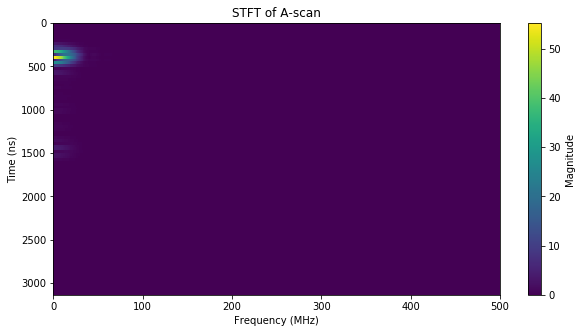

In [5]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

inputs = outputdata[:, 32]


print(inputs.shape)
f, t, Zxx = signal.stft(inputs, window='hann', nfft=1024, nperseg=64)

f = f*1000
plt.figure(figsize=(10, 5)).patch.set_facecolor('white')
plt.pcolormesh(f, t, np.abs(Zxx).transpose(), vmin=0)
plt.title("STFT of A-scan")
plt.ylim(t.max(), 0)
plt.xlim(0, f.max())
plt.ylabel('Time (ns)')
plt.xlabel('Frequency (MHz)')
plt.set_cmap('viridis')
plt.colorbar().set_label('Magnitude')

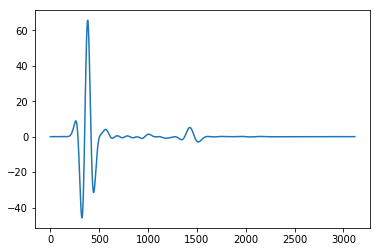

In [6]:
plt.plot(inputs)

(200, 1557)
(200, 1025)
(200, 1557)
0.5


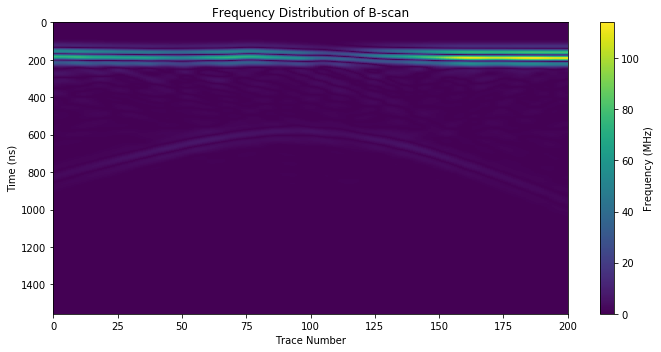

In [7]:
def stft(inputs, index):
    f, t, zxx = signal.stft(inputs[:, index], window='hann', nperseg=4, nfft=2048, padded=None, boundary=None)
    return f, t, zxx

spects = []
freqs = []
times = []
for i in range(len(outputdata[0,:])):
    f, t, zxx = stft(outputdata, i)
    freqs.append(f)
    times.append(t)
    spects.append(np.abs(zxx))
    
spects = np.array(spects)
freqs = np.array(freqs)
times = np.array(times)
spects = np.amax(spects, axis=1)
print(spects.shape)
print(freqs.shape)
print(times.shape)

print(freqs.max())
plt.figure(figsize=(10,5)).patch.set_facecolor('white')
plt.xlim(0, len(spects[:,0]))
plt.ylim(len(spects[0,:]), 0)
plt.ylabel('Time (ns)')
plt.xlabel('Trace Number')
plt.pcolormesh(spects.transpose()).set_label('Frequency (MHz)')
plt.title('Frequency Distribution of B-scan')
plt.set_cmap('viridis')
plt.tight_layout()
plt.colorbar().set_label('Frequency (MHz)')
plt.savefig('freqency_dist_bscan.png')

In [8]:
spects.reshape(2, -1).shape

(2, 155700)

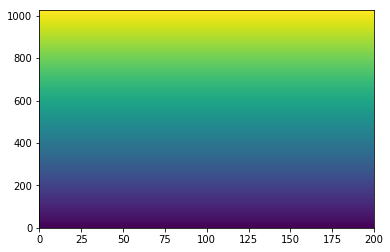

In [9]:
plt.pcolormesh(freqs.transpose())